## Ultimate Data Science Challenge
### Part 1 - Exploratory data analysis
First we import the dependencies we need.

In [25]:
import pandas as pd

The logins are stored in JSON, so we can use pandas' `read_json` method to convert the data into a pandas DataFrame for easier analysis. We can see we have one column, a list of timestamps, which are the timestamps of user logins in a particular geographic location, as per the brief.

In [26]:
user_logins = pd.read_json('logins.json', convert_dates=['login_time'])
print('Dataset columns:', user_logins.columns.values)
print('Number of logins: ', len(user_logins))
user_logins

Dataset columns: ['login_time']
Number of logins:  93142


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


The year looks to always be 1970. As unix time starts at 1970-01-01, then there's a likely chance that the actual year was never provided, just the month and date? As we're just looking at the daily trend of login times, we'll ignore the date - but it might be something to consider later on.

Let's use pandas `resample` method to get the counts of logins in 15 minute intervals:

In [27]:
by_15_min_intervals = user_logins.resample('15min', on='login_time').count()
by_15_min_intervals.columns = ['Number of logins']
by_15_min_intervals

,Number of logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


We're looking at the daily trend, so let's ignore the dates and count the number of logins in each 15 minute interval.

In [28]:
ignore_dates = by_15_min_intervals.groupby(pd.to_datetime(by_15_min_intervals.index).time).sum()

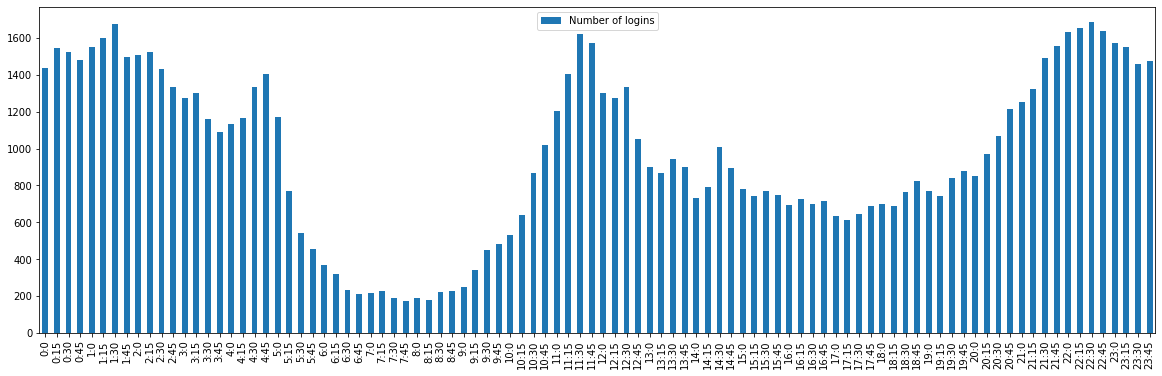

In [29]:
ax = ignore_dates.plot(kind='bar', figsize=(20,6))
ax.set_xticklabels(ignore_dates.index.map(lambda x: str(x.hour) + ':' + str(x.minute))) ;

Clearly the amount of logins differs quite a lot depending on the time of day. The amount of logins drops considerably between 5am and 10am, is consistantly moderate throughout the afternoon, and considerably higher in the late evening and early morning. The amount of logins peaks around 1:30am, 11:30am and 10:30pm.

### Part 2: Experiment and metrics design
1. *What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?*

The ultimate (no pun intended) aim of the experiment would be to stop the drivers' tendency towards a particular city. We can summarize a driver's preferred city by looking at the counts of the location of previous drives, and computing the relative difference between the counts. We can define relative difference (RD) here as the absolute difference between two numbers divided by their sum, or:

$$RD(a,b) = \frac{|a - b|}{a+b}$$

This will give us a value between 0 and 1. In this case, a value of 0 represents 0 difference between the two numbers, and a value of 1 represents a very large difference.

We can count the number of drives in one city, and the number of drives in another, and compute the relative difference. If they have rides which take them from one city to another, we can count that as a drive for both. 

For example, if a driver has 100 rides in Gotham and 900 rides in Metropolis, and 10 where they visited both, then their RD would be: (910-110)/(910+110) = 0.7843137255. If a driver had 495 rides in Gotham and 505 rides in Metropolis, and 10 where they visited both, then their RD would be (515-505)/(515+505) = 0.009803921569. The closer to 0 their RD is, the better the distribution of their drives.

I'd choose this metric as it's fairly easy to compute, and gives a clear indication of a driver's tendency towards the cities, with a simple result between 0 and 1. It would lend itself well to fine tuning ML models with a single metric, where we aim to minimise the average relative difference.


2. *Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.*

We could take a sample of drivers and compute the average relative difference between their location counts using previous driving data. We can then make the toll change for these drivers, and record the average relative difference in location counts over the course of the experiment.

We can then measure the success of the experiment by the average relative difference of all the drivers taking part in the experiment, over the time period of the experiment. 

If the average is considerably __less__ than the average relative difference before the experiment, then the experiment would have been a success. 


## Part 3: Predictive Modelling
1. *Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?*

First we load the data into a pandas DataFrame. We can't use `pd.load_json` here as the file contains `NaN` and `load_json` doesn't accommodate for that.

In [30]:
import json

with open('ultimate_data_challenge.json', 'rb') as file:
    data = json.load(file)
    ultimate_df = pd.DataFrame(data)
ultimate_df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


Let's see if we have any missing values:

In [31]:
ultimate_df.isnull().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
dtype: bool

In [32]:
ultimate_df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [33]:
ultimate_df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

Let's set the avg ratings to be 0 if they don't exist. We could simply drop the rows where it doesn't exist if this causes problems.
The `phone` column seems to have 396 empty rows. Looking at the value counts, the other values are iPhone or Android, suggesting that the 396 empty rows are another type of phone, so I'm going to fill these empty values with 'other' and then we can use one hot encoding with `iPhone`, `Android` and `other`. 

In [34]:
# Replace empty phone values with other
ultimate_df['phone'].fillna('other', inplace=True)
# Replace empty rating values with 0
ultimate_df.fillna(0, inplace=True)

In [35]:
ultimate_df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,0.0,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


We'll need to work out if a user was retained or not, according to the definition of retained as per the brief (we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days). This is quite simple, as we just need to check if `trips_in_first_30_days` is greater than 0.

In [36]:
retained_users = ultimate_df['trips_in_first_30_days'] > 0
number_retained = len(ultimate_df[retained_users])

In [37]:
percentage_retained = (number_retained / len(ultimate_df)) * 100
print('Percentage retained: {}%'.format(percentage_retained))

Percentage retained: 69.22%


2. *Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.*

We'll want to try and predict whether a user will be "active" given the rest of the data, so let's create an `active` column that we can use as our target labels - `1` if the user is active, `0` if not.

In [38]:
# create retained_column, which will be used as a prediction label
ultimate_df['retained'] = (retained_users).astype(int)

We should convert categorical data to a one hot encoding for easier modelling. We have two columns with categorical data - city and phone. We can use pandas's `get_dummies` to do this for us.

In [39]:
city_one_hot_df = pd.get_dummies(ultimate_df['city'], prefix='city')

In [40]:
phone_one_hot_df = pd.get_dummies(ultimate_df['phone'], prefix='phone')

Let's ensure we just have numerical data:

In [41]:
ultimate_black_user_int = ultimate_df['ultimate_black_user'].astype(int)

We'll ignore the signup date and last trip dates for now. Putting it all together gives us a list of features:

- city
- phone
- average distance
- average rating by driver
- average rating of driver
- surge percentage
- average surge
- ultimate black user
- percentage of trips occuring on a weekday

Let's put that all together in a dataframe:

In [42]:
stripped_df = ultimate_df[['avg_dist', 'avg_rating_of_driver', 'avg_surge', 
                           'surge_pct', 'weekday_pct', 'avg_rating_by_driver', 'retained']]
cleaned_data = pd.concat([city_one_hot_df, phone_one_hot_df,
                          ultimate_black_user_int,stripped_df], axis=1)

In [43]:
cleaned_data

,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other,ultimate_black_user,avg_dist,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_rating_by_driver,retained
0,0,1,0,0,1,0,1,3.67,4.7,1.10,15.4,46.2,5.0,1
1,1,0,0,1,0,0,0,8.26,5.0,1.00,0.0,50.0,5.0,0
2,1,0,0,0,1,0,0,0.77,4.3,1.00,0.0,100.0,5.0,1
3,0,1,0,0,1,0,1,2.36,4.6,1.14,20.0,80.0,4.9,1
4,0,0,1,1,0,0,0,3.13,4.4,1.19,11.8,82.4,4.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,0,0,1,0,0,5.63,5.0,1.00,0.0,100.0,4.2,0
49996,1,0,0,0,1,0,0,0.00,0.0,1.00,0.0,0.0,4.0,1
49997,0,0,1,1,0,0,1,3.86,5.0,1.00,0.0,100.0,5.0,0
49998,1,0,0,0,1,0,0,4.58,3.0,1.00,0.0,100.0,3.5,1


We're now ready to train an ML model for prediction. We're predicting whether or not they will be active in their 6 month of using the system. I'm assuming that when used in production, we'll have access to the features listed above, and we'll try to predict whether they are active or not.
Let's look at the distribution of each value to see if there's anything we should be aware of:


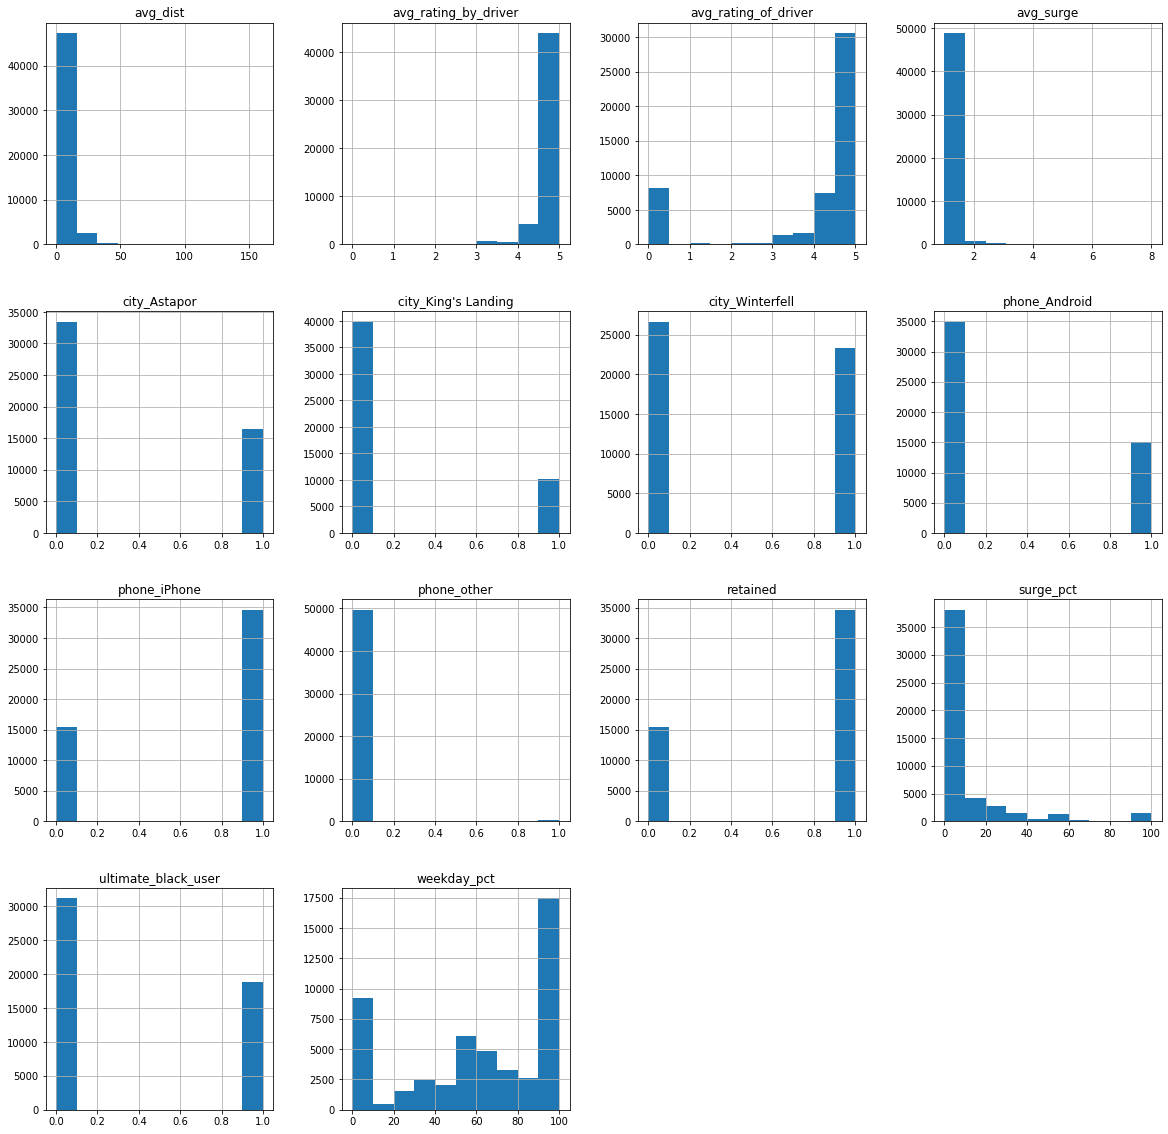

In [44]:
ax = cleaned_data.hist(figsize=(20,20)) ;

We can tell a few things from this plot of histograms. The things that pop out for me are the fact that the average rating by driver is typically between 4 and 5, and the average rating of a user's driver is typically between 4 and 5 or between 0 and 0.5, with not much in between.

Let's look at the relationship between some of the features and the `retained` column to see if there is a linear relationship:

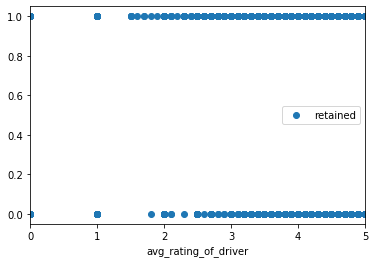

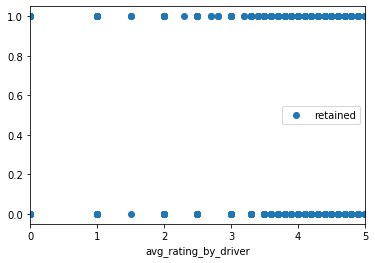

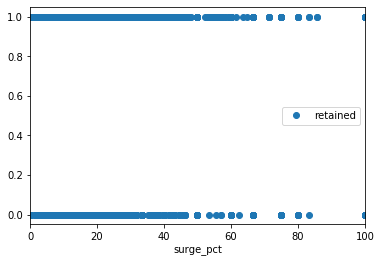

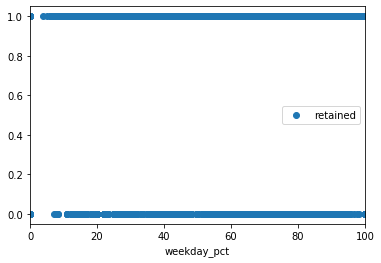

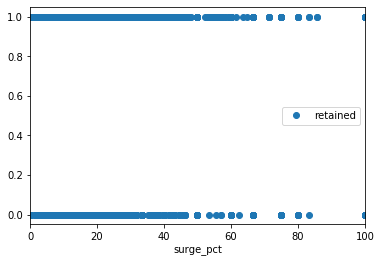

In [45]:
cleaned_data.plot(x='avg_rating_of_driver', y='retained', style='o')
cleaned_data.plot(x='avg_rating_by_driver', y='retained', style='o')
cleaned_data.plot(x='surge_pct', y='retained', style='o')
cleaned_data.plot(x='weekday_pct', y='retained', style='o')
cleaned_data.plot(x='surge_pct', y='retained', style='o')

Looks like there isn't a clear relationship here.

Let's look at whether or not the location or city has an effect on activity:

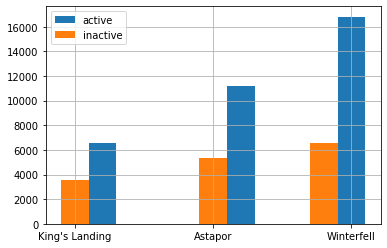

In [218]:
ax = ultimate_df[ultimate_df['retained'] == 1]['city'].hist(align='right') ;
ultimate_df[ultimate_df['retained'] == 0]['city'].hist(ax=ax, align='left') ;

labels= ["active","inactive"]
ax.legend(labels) ;


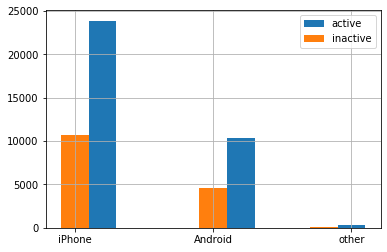

In [226]:
ax = ultimate_df[ultimate_df['retained'] == 1]['phone'].hist(align='right') ;
ultimate_df[ultimate_df['retained'] == 0]['phone'].hist(ax=ax, align='left') ;

labels= ["active","inactive"]
ax.legend(labels) ;


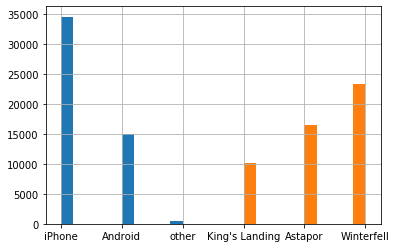

In [227]:
ultimate_df['phone'].hist()
ultimate_df['city'].hist()

Looks like the city or phone has no clear impact on whether the user will be active, as the distribution of active vs inactive matches the regular distribution.

Before we train a model and try to find a relationship, let's split our data into training and testing, so we can correctly evaluate our performance. We'll be performing cross validation to find the best hyperparameters to our model.

In [46]:
from sklearn.model_selection import train_test_split

y = cleaned_data['retained']
X = cleaned_data.drop('retained', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

print("Subset sizes:")
print("Training:", len(X_train))
print("Testing:", len(X_test))

Subset sizes:
Training: 40000
Testing: 10000


Let's look at the class distribution for our training data:

In [59]:
count_class_1, count_class_0 = y_train.value_counts()
count_class_1, count_class_0
y_train.value_counts()

1    27714
0    12286
Name: retained, dtype: int64

We have over twice as much occurrences of active users than inactive users, so we should do some sampling to ensure we don't overfit to the more common class. As we have around 12,000 occurrences of inactive users, random undersampling should be fine, but we might want to look into better undersampling methods or oversampling methods in the future:

Random under-sampling:
1    12286
0    12286
Name: retained, dtype: int64


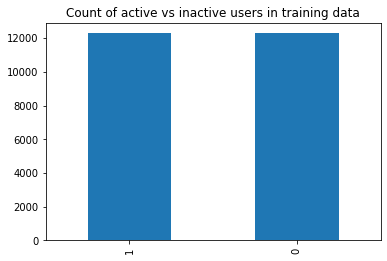

In [80]:
class_0 = y_train[y_train == 0]
class_1 = y_train[y_train == 1]

class_1_undersample = class_1.sample(count_class_0)
y_undersample = pd.concat([class_1_undersample, class_0], axis=0)

print('Random under-sampling:')
print(y_undersample.value_counts())

y_undersample.value_counts().plot(kind='bar', title='Count of active vs inactive users in training data');

In [76]:
X_undersample = X_train[X_train.index.isin(y_undersample.index)]

We'll need to normalize the data, as it's quite skewed:

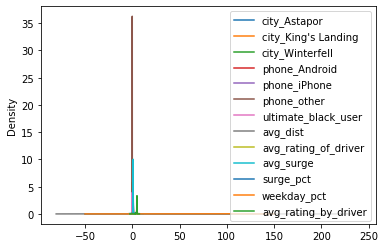

In [93]:
X_undersample.plot.kde()

In [100]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_undersample)
X_test_scaled = scaler.transform(X_test)

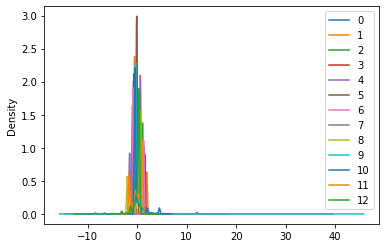

In [101]:
pd.DataFrame(X_train_scaled).plot.kde()

Let's start simple, with a Logistic Regression model. We'll perform cross validation using grid search to find the best parameters for Logistic Regression:

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

LR_params = {'C': [0.001,0.01,0.1,1,10,100,1000], 
             'penalty': ['l1', 'l2'],
            }

classifier = GridSearchCV(LogisticRegression(), LR_params, verbose=1)
classifier.fit(X_train_scaled, y_undersample)

print(classifier.best_params_)
print(classifier.best_score_)

y_true, y_pred = y_test, classifier.predict(X_test)
print(classification_report(y_true, y_pred))

print(confusion_matrix(y_true, y_pred))

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 0.1, 'penalty': 'l1'}
0.5072033208530035
              precision    recall  f1-score   support

           0       0.41      0.18      0.25      3104
           1       0.71      0.88      0.78      6896

    accuracy                           0.66     10000
   macro avg       0.56      0.53      0.52     10000
weighted avg       0.61      0.66      0.62     10000

[[ 558 2546]
 [ 807 6089]]


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    2.8s finished


This isn't great, can we do better with other classification algorithms?

In [235]:
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [200, 700]
}

classifier = GridSearchCV(RandomForestClassifier(), param_grid, verbose=1)

classifier.fit(X_train_scaled, y_undersample)

print(classifier.best_params_)
print(classifier.best_score_)

print(classifier.best_estimator_.feature_importances_)

y_true, y_pred = y_test, classifier.predict(X_test)
print(classification_report(y_true, y_pred))

print(confusion_matrix(y_true, y_pred))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.5min finished


{'max_features': 'sqrt', 'n_estimators': 700}
0.5063893862933421
[0.00821682 0.00745296 0.00842985 0.00668982 0.00669478 0.00148497
 0.01743018 0.56395336 0.08963259 0.05435844 0.04936697 0.10979802
 0.07649125]
              precision    recall  f1-score   support

           0       0.29      0.43      0.35      3104
           1       0.67      0.53      0.60      6896

    accuracy                           0.50     10000
   macro avg       0.48      0.48      0.47     10000
weighted avg       0.55      0.50      0.52     10000

[[1320 1784]
 [3217 3679]]


In [233]:
print(classifier.best_estimator_.feature_importances_)
for feat, importance in zip(X_train.columns, classifier.best_estimator_.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))


[0.00822243 0.00734375 0.0081268  0.00672566 0.00672686 0.0014951
 0.01749888 0.56442209 0.0890099  0.05376212 0.04946207 0.11024594
 0.07695841]
feature: city_Astapor, importance: 0.008222429735552345
feature: city_King's Landing, importance: 0.0073437471091149864
feature: city_Winterfell, importance: 0.00812680180093374
feature: phone_Android, importance: 0.006725655081225594
feature: phone_iPhone, importance: 0.006726862807401106
feature: phone_other, importance: 0.0014951002799313401
feature: ultimate_black_user, importance: 0.0174988835126784
feature: avg_dist, importance: 0.5644220886064283
feature: avg_rating_of_driver, importance: 0.08900989566433773
feature: avg_surge, importance: 0.053762116654606756
feature: surge_pct, importance: 0.04946206994459718
feature: weekday_pct, importance: 0.11024593698281959
feature: avg_rating_by_driver, importance: 0.07695841182037313


In [229]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


param_grid = {
    'base_estimator__max_depth' : [1, 2, 3, 4, 5],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
}
bagging  = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100, max_features = 0.5)
classifier = GridSearchCV(bagging, param_grid)

classifier.fit(X_train_scaled, y_undersample)

print(classifier.best_params_)
print(classifier.best_score_)

y_true, y_pred = y_test, classifier.predict(X_test)
print(classification_report(y_true, y_pred))

print(confusion_matrix(y_true, y_pred))

{'base_estimator__max_depth': 1, 'max_samples': 0.1}
0.5084649194204786
              precision    recall  f1-score   support

           0       0.31      0.75      0.43      3104
           1       0.67      0.23      0.35      6896

    accuracy                           0.39     10000
   macro avg       0.49      0.49      0.39     10000
weighted avg       0.56      0.39      0.37     10000

[[2326  778]
 [5288 1608]]


In [234]:
print(classifier.best_estimator_.feature_importances_)
for feat, importance in zip(X_train.columns, classifier.best_estimator_.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))


[0.00822243 0.00734375 0.0081268  0.00672566 0.00672686 0.0014951
 0.01749888 0.56442209 0.0890099  0.05376212 0.04946207 0.11024594
 0.07695841]
feature: city_Astapor, importance: 0.008222429735552345
feature: city_King's Landing, importance: 0.0073437471091149864
feature: city_Winterfell, importance: 0.00812680180093374
feature: phone_Android, importance: 0.006725655081225594
feature: phone_iPhone, importance: 0.006726862807401106
feature: phone_other, importance: 0.0014951002799313401
feature: ultimate_black_user, importance: 0.0174988835126784
feature: avg_dist, importance: 0.5644220886064283
feature: avg_rating_of_driver, importance: 0.08900989566433773
feature: avg_surge, importance: 0.053762116654606756
feature: surge_pct, importance: 0.04946206994459718
feature: weekday_pct, importance: 0.11024593698281959
feature: avg_rating_by_driver, importance: 0.07695841182037313


Ideally we'd want high precision and recall here, but if we have to choose one to optimize, we'd want to optimize recall, as we care more about identifying if a user will not be active than if they will be active. If we predict they will not be active and they are then there's no problem, but if we predict they will be active and they aren't then we have a greater problem.

3. *Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).*

After finding the most accurate model, using feature importances can give us a good idea of what features make an impact on user retention. Using the models above it's clear that average distance is the most important, so presumably the longer the journey a user makes, the more loyal they will be.
Some ML models are easier to visualize, for instance we could create a decision tree plot which shows on what features it's splitting on and at which point.